In [25]:
import seaborn as sns
import numpy as np 
import pandas as pd

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [45]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [46]:
categorical_columns = df.select_dtypes(include=["object"]).columns
numerical_columns = df.select_dtypes(include=["number"]).columns

In [47]:
print(categorical_columns, numerical_columns)

Index(['ocean_proximity'], dtype='object') Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value'],
      dtype='object')


In [48]:
for c in categorical_columns:
    print(f"Column: {c}")
    print(df[c].value_counts())

Column: ocean_proximity
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


In [49]:
columns = ['latitude', 'longitude', 'housing_median_age',
'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income',
'median_house_value']

In [50]:
filtered_df = df[columns]
filtered_df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

In [51]:
len(filtered_df)

15687

c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\machine-learning-zoomcamp-23-gSc8i9dl-py3.9\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Dell\AppData\Local\pypoetry\Cache\virtualenvs\machine-learning-zoomcamp-23-gSc8i9dl-py3.9\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='median_house_value', ylabel='Count'>

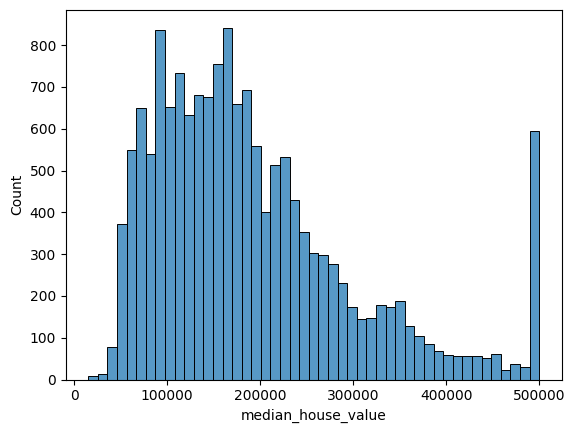

In [52]:
sns.histplot(filtered_df.median_house_value)

Question 1

In [53]:
filtered_df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Question 2

In [54]:
filtered_df["population"].median()

1195.0

Question 3

In [55]:
np.random.seed(42)
n = len(filtered_df)
n_test = int(0.2*n) 
n_val = int(0.2*n)
n_train = n - n_test - n_val 

print(n, n_train, n_test, n_val)

15687 9413 3137 3137


In [56]:
idx = np.arange(n)
np.random.shuffle(idx)

filtered_df_val = filtered_df.iloc[idx[:n_val]]
filtered_df_test = filtered_df.iloc[idx[n_val:n_val+n_test]]
filtered_df_train = filtered_df.iloc[idx[n_val+n_test:]]

print(f"Shape of validation dataset: {filtered_df_val.shape}")
print(f"Shape of test dataset: {filtered_df_test.shape}")
print(f"Shape of train dataset: {filtered_df_train.shape}")

Shape of validation dataset: (3137, 10)
Shape of test dataset: (3137, 10)
Shape of train dataset: (9413, 10)


In [57]:
filtered_df_train = filtered_df_train.reset_index(drop=True)
filtered_df_val = filtered_df_val.reset_index(drop=True)
filtered_df_test = filtered_df_test.reset_index(drop=True)

In [58]:
y_train = np.log1p(filtered_df_train.median_house_value.values)
y_test = np.log1p(filtered_df_test.median_house_value.values)
y_val = np.log1p(filtered_df_val.median_house_value.values)

print(f"Length of y_train: {len(y_train)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_val: {len(y_val)}")

Length of y_train: 9413
Length of y_test: 3137
Length of y_val: 3137


In [59]:
del filtered_df_train["median_house_value"]
del filtered_df_test["median_house_value"]
del filtered_df_val["median_house_value"]

In [65]:
ocean_proximity_values = list(filtered_df.ocean_proximity.value_counts().head().index)

In [72]:
def prepare_X(df):
    df_num = df.copy()

    for v in ocean_proximity_values:
        df_num[f"ocean_proximity_{v}"] = (df.ocean_proximity == v).astype("int")

    del df_num["ocean_proximity"]
    return df_num.fillna(0).values 

In [73]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    w_0 = w[0]
    w_full = w[1:]

    return w_0, w_full 

In [74]:
def rmse(y, y_pred):
    error = y - y_pred 
    se = error**2 
    mse = se.mean()
    return np.sqrt(mse)

In [75]:
X_train = prepare_X(filtered_df_train)
X_test = prepare_X(filtered_df_test)
X_val = prepare_X(filtered_df_val)

In [76]:
W0, W_full = train_linear_regression(X_train, y_train)

In [77]:
y_val_pred = W0 + X_val.dot(W_full)
rmse(y_val, y_val_pred)

53.40547594224753

In [78]:
def prepare_X(df):
    df_num = df.copy()

    for v in ocean_proximity_values:
        df_num[f"ocean_proximity_{v}"] = (df.ocean_proximity == v).astype("int")

    del df_num["ocean_proximity"]
    return df_num.fillna(df_num.mean()).values 

In [79]:
X_train = prepare_X(filtered_df_train)
X_test = prepare_X(filtered_df_test)
X_val = prepare_X(filtered_df_val)

In [80]:
W0, W_full = train_linear_regression(X_train, y_train)

In [81]:
y_val_pred = W0 + X_val.dot(W_full)
rmse(y_val, y_val_pred)

19.73128574275605

In [94]:
def prepare_X(df):
    df_num = df.copy()

    for v in ocean_proximity_values:
        df_num[f"ocean_proximity_{v}"] = (df.ocean_proximity == v).astype("int")

    del df_num["ocean_proximity"]
    return df_num.fillna(0).values 

In [83]:
def train_linear_regression_reg(X, y, r=0.001):
    """Train a linear regression model with regularization"""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r*np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    w_0 = w[0]
    w_full = w[1:]

    return w_0, w_full 

In [84]:
# Iterative over a non-exhaustive list of values
best_score = np.inf
best_r = 0 
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(filtered_df_train)
    W0, W = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(filtered_df_val)
    y_val_pred = W0 + X_val.dot(W)
    val_rmse_score = rmse(y_val, y_val_pred)

    print(f"For r={r}: RMSE score = {val_rmse_score}")

    if val_rmse_score < best_score:
        best_score = val_rmse_score 
        best_r = r

print("------")
print(f"Best r = {best_r} with score {best_score}")

For r=0: RMSE score = 53.40547594224753
For r=1e-06: RMSE score = 0.3188733562917852
For r=0.0001: RMSE score = 0.3188734594295471
For r=0.001: RMSE score = 0.3188734951974854
For r=0.01: RMSE score = 0.3188738643313666
For r=0.1: RMSE score = 0.3188783737718456
For r=1: RMSE score = 0.3189106080620089
For r=5: RMSE score = 0.318933164856659
For r=10: RMSE score = 0.318936301550423
------
Best r = 1e-06 with score 0.3188733562917852


In [95]:
np.random.seed(9)
n = len(filtered_df)
n_test = int(0.2*n) 
n_val = int(0.2*n)
n_train = n - n_test - n_val 

print(n, n_train, n_test, n_val)

15687 9413 3137 3137


In [96]:
idx = np.arange(n)
np.random.shuffle(idx)

filtered_df_val = filtered_df.iloc[idx[:n_val]]
filtered_df_test = filtered_df.iloc[idx[n_val:n_val+n_test]]
filtered_df_train = filtered_df.iloc[idx[n_val+n_test:]]

print(f"Shape of validation dataset: {filtered_df_val.shape}")
print(f"Shape of test dataset: {filtered_df_test.shape}")
print(f"Shape of train dataset: {filtered_df_train.shape}")

Shape of validation dataset: (3137, 10)
Shape of test dataset: (3137, 10)
Shape of train dataset: (9413, 10)


In [97]:
filtered_df_train_full = pd.concat([filtered_df_train, filtered_df_val])

In [98]:
filtered_df_train_full = filtered_df_train_full.reset_index(drop=True)
filtered_df_test = filtered_df_test.reset_index(drop=True)

In [99]:
filtered_df_train_full.shape 

(12550, 10)

In [100]:
y_train_full = np.log1p(filtered_df_train_full.median_house_value.values)
y_test = np.log1p(filtered_df_test.median_house_value.values)

print(f"Length of y_train_full: {len(y_train_full)}")
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_val: {len(y_val)}")

Length of y_train_full: 12550
Length of y_test: 3137
Length of y_val: 3137


In [101]:
del filtered_df_train_full["median_house_value"]
del filtered_df_test["median_house_value"]

In [102]:
X_train_full = prepare_X(filtered_df_train_full)
W0, W = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)

X_test = prepare_X(filtered_df_test)
y_pred_test = W0 + X_test.dot(W)

rmse(y_val, y_pred_test)

0.7304574254486865